In [121]:
import pandas as pd
import matplotlib
import folium
import branca.colormap as cm
import os
from h3 import h3
from tqdm import tqdm
from geojson.feature import *
import json
import geojson

In [135]:
df = pd.read_excel('data.xls')
df = df[['Longitude', 'Latitude']]
df = df.rename(columns={"Longitude": "lng", "Latitude": "lat"})
df.drop(df[df['lng'] < 120.81].index, inplace = True)
df.drop(df[df['lng'] > 122.12].index, inplace = True)
df.drop(df[df['lat'] < 30.40].index, inplace = True)
df.drop(df[df['lat'] > 31.53].index, inplace = True)
df.head()

,lng,lat
0,121.489484,31.240373
1,121.460855,31.295211
2,121.440338,31.419139
3,121.460855,31.295211
4,121.543922,31.278916


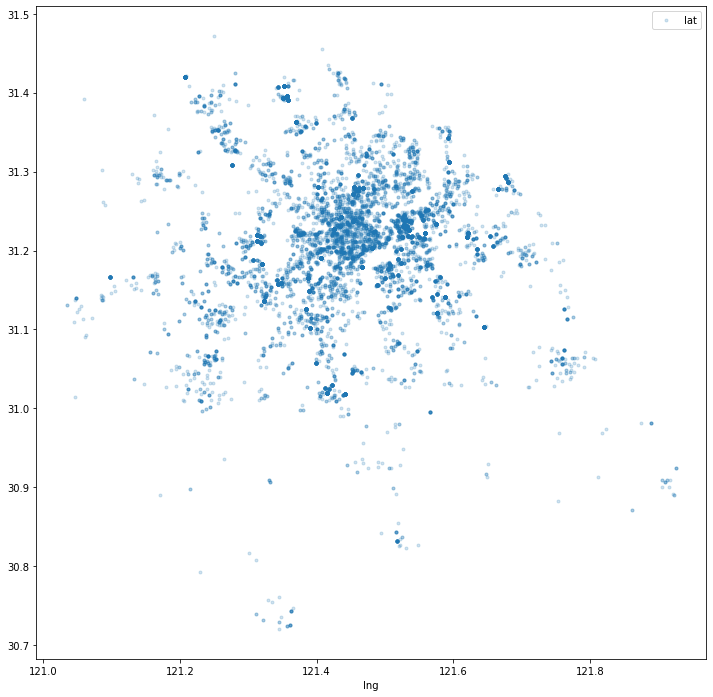

In [136]:
df.plot(x='lng',y='lat',style='.',alpha=0.2,figsize=(12,12));

In [182]:
def counts_by_hexagon(df, resolution):
    """
    Use h3.geo_to_h3 to index each data point into the spatial index of the specified resolution.
    Use h3.h3_to_geo_boundary to obtain the geometries of these hexagons
    
    Ex counts_by_hexagon(data, 9)
    """
    df = df[["lat","lng"]]
    
    df["hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["lat"], row["lng"], resolution), axis = 1)
    
    df_aggreg = df.groupby(by = "hex_id").size().reset_index()
    df_aggreg.columns = ["hex_id", "value"]
    
    df_aggreg["geometry"] =  df_aggreg.hex_id.apply(lambda x: 
                                                           {    "type" : "Polygon",
                                                                 "coordinates": 
                                                                [h3.h3_to_geo_boundary(h=x,geo_json=True)]
                                                            }
                                                        )
    
    return df_aggreg

def hexagons_dataframe_to_geojson(df_hex, file_output = None):
    """
    Produce the GeoJSON for a dataframe that has a geometry column in geojson 
    format already, along with the columns hex_id and value
    
    Ex counts_by_hexagon(data)
    """    
    list_features = []
    
    for i,row in df_hex.iterrows():
        feature = Feature(geometry = row["geometry"] , id=row["hex_id"], properties = {"value" : row["value"]})
        list_features.append(feature)
        
    feat_collection = FeatureCollection(list_features)
    
    geojson_result = json.dumps(feat_collection)
    
    #optionally write to file
    if file_output is not None:
        with open(file_output,"w") as f:
            json.dump(feat_collection,f)
    
    return geojson_result


def choropleth_map(df_aggreg, border_color = 'black', fill_opacity = 0.7, initial_map = None, with_legend = False,
                   kind = "linear"):
    
    """
    Creates choropleth maps given the aggregated data.
    """    
    #colormap
    min_value = df_aggreg["value"].min()
    max_value = df_aggreg["value"].max()
    m = round ((min_value + max_value ) / 2 , 0)
    
    #take resolution from the first row
    res = h3.h3_get_resolution(df_aggreg.loc[0,'hex_id'])
    
    if initial_map is None:
        initial_map = folium.Map(location= [40.718728, -73.943802], zoom_start=12, tiles="cartodbpositron", 
                attr= '© <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors © <a href="http://cartodb.com/attributions#basemaps">CartoDB</a>' 
            )
        

    #the colormap 
    #color names accepted https://github.com/python-visualization/branca/blob/master/branca/_cnames.json
    if kind == "linear":
        custom_cm = cm.LinearColormap([(0,200,0,128),(128,128,0,128),(255,0,0,128)], index=[min_value,250,max_value], vmin=min_value, vmax=max_value)
    elif kind == "outlier":
        #for outliers, values would be -11,0,1
        custom_cm = cm.LinearColormap(['blue','white','red'], vmin=min_value, vmax=max_value)
    elif kind == "filled_nulls":
        custom_cm = cm.LinearColormap(['sienna','green','yellow','red'], 
                                      index=[0,min_value,m,max_value],vmin=min_value,vmax=max_value)
   

    #create geojson data from dataframe
    geojson_data = hexagons_dataframe_to_geojson(df_hex = df_aggreg)
    
    #plot on map
    name_layer = "Choropleth " + str(res)
    if kind != "linear":
        name_layer = name_layer + kind
        
    folium.GeoJson(
        geojson_data,
        style_function=lambda feature: {
            'fillColor': custom_cm(feature['properties']['value']),
            'color': border_color,
            'weight': 1,
            'fillOpacity': fill_opacity 
        }, 
        name = name_layer
    ).add_to(initial_map)
    #add legend (not recommended if multiple layers)
    if with_legend == True:
        custom_cm.add_to(initial_map)
    
    
    
    return initial_map

def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16,12), colormap='viridis'):
    """
    Scatter plot function for h3 indexed objects
    """    
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize);
    plt.xticks([], []); plt.yticks([], [])

In [183]:
# Counts how many points are within the hex
df_aggreg = counts_by_hexagon(df = df, resolution = 6)
df_aggreg.sort_values(by = "value", ascending = False, inplace = True)
# Creates a map using Folium
hexmap = choropleth_map(df_aggreg = df_aggreg, with_legend = True)
hexmap

<ipython-input-182-5adae4d2712c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["lat"], row["lng"], resolution), axis = 1)
